In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'alg'))

In [2]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from algorithm import *
from explainer import *
from genetic import *
import dalex as dx
from LR import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
data = pd.read_csv('../../../Dataset/Kaggle-data.csv')
data.head()

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.


,ID,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,Unnamed: 57
0,1,b69acb3bb133974e48229627663f96d4,332,224,8450,8.0,0,16896,8192,0,...,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1,NaN
1,2,1cbee4b3725629bd0aa6ac2ff500925f,332,224,258,9.0,0,84480,25600,0,...,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1,NaN
2,3,b7027cf0cd31c820928950cbfe7e91ef,332,224,8450,8.0,0,4608,3584,0,...,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1,NaN
3,4,156a0bb069f94d1e7c2508318805f2a4,332,224,8450,10.0,0,108544,15872,0,...,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1,NaN
4,5,c72bf851fed5542abba904b1f3944cd5,332,224,8226,48.0,0,513024,2048,0,...,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1,NaN


In [4]:
data = data.drop(columns=['ID', 'Unnamed: 57'])
data.head()

,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,b69acb3bb133974e48229627663f96d4,332,224,8450,8.0,0,16896,8192,0,16947,...,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1
1,1cbee4b3725629bd0aa6ac2ff500925f,332,224,258,9.0,0,84480,25600,0,10973,...,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1
2,b7027cf0cd31c820928950cbfe7e91ef,332,224,8450,8.0,0,4608,3584,0,6452,...,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1
3,156a0bb069f94d1e7c2508318805f2a4,332,224,8450,10.0,0,108544,15872,0,105021,...,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1
4,c72bf851fed5542abba904b1f3944cd5,332,224,8226,48.0,0,513024,2048,0,520922,...,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1


In [5]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data = data.dropna(axis=1)
data.head()

,SizeOfOptionalHeader,Characteristics,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,224,8450,0,16896,8192,0,16947,4096,24576,4194304.0,...,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1
1,224,258,0,84480,25600,0,10973,4096,90112,65536.0,...,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1
2,224,8450,0,4608,3584,0,6452,4096,12288,264962048.0,...,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1
3,224,8450,0,108544,15872,0,105021,4096,114688,268435456.0,...,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1
4,224,8226,0,513024,2048,0,520922,8192,524288,268435456.0,...,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216352 entries, 0 to 216351
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SizeOfOptionalHeader         216352 non-null  int64  
 1   Characteristics              216352 non-null  int64  
 2   MinorLinkerVersion           216352 non-null  int64  
 3   SizeOfCode                   216352 non-null  int64  
 4   SizeOfInitializedData        216352 non-null  int64  
 5   SizeOfUninitializedData      216352 non-null  int64  
 6   AddressOfEntryPoint          216352 non-null  int64  
 7   BaseOfCode                   216352 non-null  int64  
 8   BaseOfData                   216352 non-null  int64  
 9   ImageBase                    216352 non-null  float64
 10  SectionAlignment             216352 non-null  int64  
 11  FileAlignment                216352 non-null  int64  
 12  MajorOperatingSystemVersion  216352 non-null  int64  
 13 

In [7]:
data.iloc[121875]

SizeOfOptionalHeader           2.240000e+02
Characteristics                2.580000e+02
MinorLinkerVersion             0.000000e+00
SizeOfCode                     1.198080e+05
SizeOfInitializedData          3.758080e+05
SizeOfUninitializedData        0.000000e+00
AddressOfEntryPoint            6.099600e+04
BaseOfCode                     4.096000e+03
BaseOfData                     1.269760e+05
ImageBase                      4.194304e+06
SectionAlignment               4.096000e+03
FileAlignment                  5.120000e+02
MajorOperatingSystemVersion    5.000000e+00
MinorOperatingSystemVersion    1.000000e+00
MajorImageVersion              0.000000e+00
MinorImageVersion              0.000000e+00
MajorSubsystemVersion          5.000000e+00
MinorSubsystemVersion          1.000000e+00
SizeOfImage                    5.160960e+05
SizeOfHeaders                  1.024000e+03
CheckSum                       5.388080e+05
Subsystem                      2.000000e+00
DllCharacteristics             3

In [8]:
protected_feature = 'Subsystem'

In [9]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='legitimate',
        protected_feature=protected_feature,
        do_scaling=True,
        scale_all_features=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling ALL numerical features as requested (scale_all_features=True).
Features actually being scaled: ['SizeOfOptionalHeader', 'Characteristics', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MajorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'Subsystem', 'SizeOfStackReserve', 'SectionsNb', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'ImportsNbDLL', 'ImportsNb', 'ExportNb', 'ResourcesNb', 'ResourcesMeanEntropy', 'ResourcesMeanSize', 'LoadConfigurationSize', 'VersionInformationSize']


In [10]:
print(len(x_train.columns))
x_train.head()

29


,SizeOfOptionalHeader,Characteristics,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,ImageBase,SectionAlignment,FileAlignment,...,SectionsMeanRawsize,SectionsMinRawsize,ImportsNbDLL,ImportsNb,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMeanSize,LoadConfigurationSize,VersionInformationSize
23719,-0.305427,0.486617,-0.012571,-0.019644,-0.018098,-0.013143,-0.008823,-0.006803,-0.005958,-0.264477,...,-0.019011,-0.059338,0.026381,0.428386,-0.085713,-0.155414,-0.191340,-0.006211,-0.021652,-0.976969
76197,-0.305427,3.645773,-0.002361,-0.000923,-0.018098,0.014050,-0.008823,-0.006803,-0.005958,-0.264477,...,-0.006661,-0.062737,0.009141,1.898300,-0.089408,2.955649,1.994856,-0.006194,-0.021655,-0.976969
26038,-0.305427,0.486617,-0.006133,-0.018636,-0.018098,-0.018213,-0.008823,-0.006803,-0.005958,-0.264477,...,-0.015771,-0.059338,0.029829,1.109036,-0.019210,-0.140051,-0.321922,-0.006127,-0.021652,-0.976969
201594,-0.305427,-0.560471,-0.018263,-0.004957,-0.017868,-0.026694,-0.008823,-0.006803,-0.005958,-0.264477,...,-0.019720,-0.062737,-0.000053,0.421146,-0.089408,-0.001782,-0.254559,-0.005931,-0.021655,-0.976969
211321,-0.305427,-0.560471,-0.014288,-0.007098,-0.018098,-0.021836,-0.008823,-0.006803,-0.005958,-0.264477,...,-0.009384,-0.030447,-0.001203,0.008411,-0.089408,0.005900,2.325660,-0.005507,-0.021654,0.763062


In [11]:
feature_names

['SizeOfOptionalHeader',
 'Characteristics',
 'SizeOfCode',
 'SizeOfInitializedData',
 'SizeOfUninitializedData',
 'AddressOfEntryPoint',
 'BaseOfCode',
 'ImageBase',
 'SectionAlignment',
 'FileAlignment',
 'MajorOperatingSystemVersion',
 'MajorImageVersion',
 'MajorSubsystemVersion',
 'MinorSubsystemVersion',
 'SizeOfHeaders',
 'CheckSum',
 'Subsystem',
 'SizeOfStackReserve',
 'SectionsNb',
 'SectionsMeanRawsize',
 'SectionsMinRawsize',
 'ImportsNbDLL',
 'ImportsNb',
 'ExportNb',
 'ResourcesNb',
 'ResourcesMeanEntropy',
 'ResourcesMeanSize',
 'LoadConfigurationSize',
 'VersionInformationSize']

In [12]:
# Assuming X_train, X_test, y_train, y_test are already separated
# And df is the original DataFrame with its original column names (e.g., 'thalach', 'trestbps', 'chol')

# Define VARIABLES_TO_CHANGE using the original column names
VARIABLES_TO_CHANGE = ['SizeOfOptionalHeader', 'Characteristics', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MajorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'SizeOfStackReserve', 'SectionsNb', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'ImportsNbDLL', 'ImportsNb', 'ExportNb', 'ResourcesNb', 'ResourcesMeanEntropy', 'ResourcesMeanSize', 'LoadConfigurationSize', 'VersionInformationSize']

# Define the full list of columns you want to select for your features
selected_columns = [protected_feature] + VARIABLES_TO_CHANGE

# Apply the column selection to X_train and X_test
x_train = x_train.loc[:, selected_columns]
x_test = x_test.loc[:, selected_columns]

# y_train and y_test remain unchanged as they already contain the target variable

Accuracy: 0.9073275197978615
Precision: 0.9076388851640118
Recall: 0.9073275197978615
F-1: 0.9059466184560997


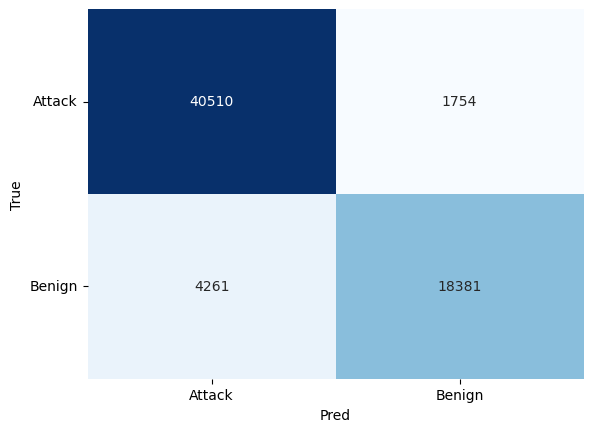

In [13]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

In [14]:
explainer = Explainer(model, x_test, 'l')

In [15]:
e = dx.Explainer(model, x_test, y_test, verbose=False)
e.model_performance()

,recall,precision,f1,accuracy,auc
LogisticRegression,0.81181,0.912888,0.859387,0.907328,0.945785


In [16]:
# pd.DataFrame({'variable': x_train.columns, 'importance_split': model.feature_importances_,
#               'importance_shap': explainer.shap_values(explainer.data),
#               'importance_perm': e.model_parts(B=25).result.sort_values("variable").iloc[2::,:].dropout_loss})


In [17]:
y_test = list(y_test)

In [18]:
I = 7
for i in range(len(y_test)):
    if y_test[i]==0:
        I=i
        break
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I)
e.data.iloc[[I]].assign(y=e.y[[I]], y_hat=e.y_hat[[I]])

,Subsystem,SizeOfOptionalHeader,Characteristics,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,ImageBase,SectionAlignment,...,ImportsNbDLL,ImportsNb,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMeanSize,LoadConfigurationSize,VersionInformationSize,y,y_hat
121875,-0.425249,-0.305427,-0.560471,-0.014243,-0.007382,-0.018098,-0.021721,-0.008823,-0.006803,-0.005958,...,-0.001203,-0.006071,-0.089408,-0.017145,2.34567,-0.005411,-0.021654,0.88735,0,0.103487


In [19]:
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I, alpha=0.75, pop_count=100)
t = a.explainer.shap_values(a._X, a._x)
t = np.array([i + (t[0] / (len(t) - 3)) if i > 0 else i - (t[0] / (len(t) - 3)) for i in t])
t[0] = -0.005
pd.DataFrame({'variable': a.explainer.data.columns, 'shap_values': a.explainer.shap_values(a._X, a._x), 'target': t})

,variable,shap_values,target
0,Subsystem,7.783594e-01,-0.005000
1,SizeOfOptionalHeader,4.738105e-01,0.503747
2,Characteristics,7.624644e-01,0.792401
3,SizeOfCode,3.525525e-04,0.030289
4,SizeOfInitializedData,1.696420e-02,0.046901
5,SizeOfUninitializedData,5.768056e-03,0.035705
6,AddressOfEntryPoint,1.139173e-01,0.143854
7,BaseOfCode,1.159054e-02,0.041527
8,ImageBase,6.014811e-05,0.029997
9,SectionAlignment,4.114895e-04,0.030348


In [20]:
a.fool_aim(target=t, max_iter=100, random_state=0)

Iter: 100 || Loss: 0.4160146888477442: 100%|██████████| 100/100 [12:01:38<00:00, 432.98s/it] 


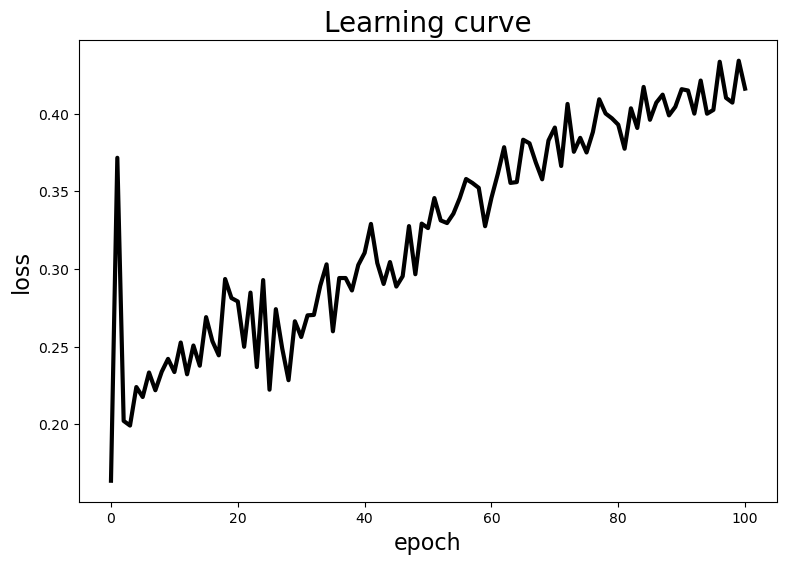

In [21]:
a.plot_losses()

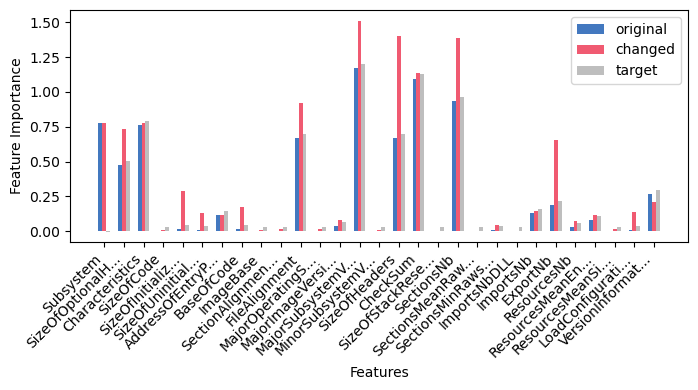

In [22]:
a.plot_explanation()

In [24]:
VARIABLES_TO_CHANGE

['SizeOfOptionalHeader',
 'Characteristics',
 'SizeOfCode',
 'SizeOfInitializedData',
 'SizeOfUninitializedData',
 'AddressOfEntryPoint',
 'BaseOfCode',
 'ImageBase',
 'SectionAlignment',
 'FileAlignment',
 'MajorOperatingSystemVersion',
 'MajorImageVersion',
 'MajorSubsystemVersion',
 'MinorSubsystemVersion',
 'SizeOfHeaders',
 'CheckSum',
 'SizeOfStackReserve',
 'SectionsNb',
 'SectionsMeanRawsize',
 'SectionsMinRawsize',
 'ImportsNbDLL',
 'ImportsNb',
 'ExportNb',
 'ResourcesNb',
 'ResourcesMeanEntropy',
 'ResourcesMeanSize',
 'LoadConfigurationSize',
 'VersionInformationSize']

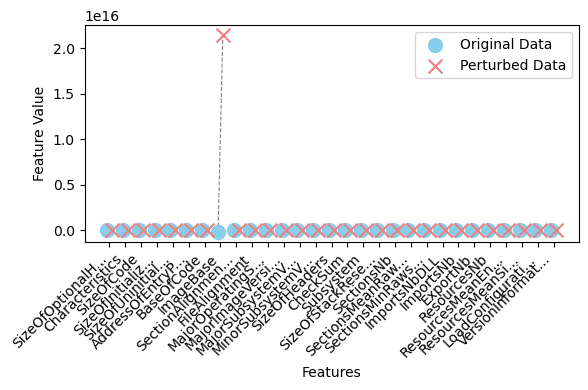

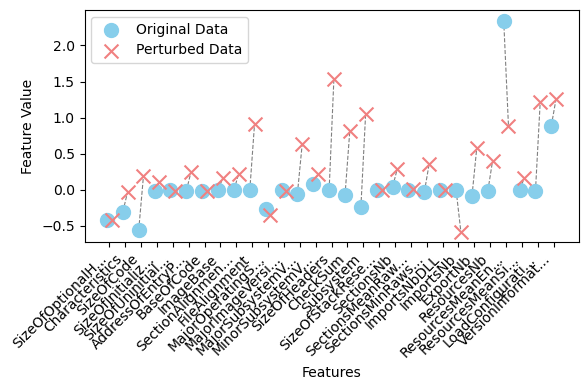

In [31]:
a.plot_data(scaler=scaler, numerical_features_scaled=VARIABLES_TO_CHANGE, all_feature_names=feature_names)
a.plot_data(all_feature_names=feature_names)

In [32]:
a.display_feature_rank_changes()


--- Feature Ranking Changes ---

Ranking Changes: Original vs. Changed Explanation
--------------------------------------------------
Feature 'CheckSum': Rank changed from 2 to 4
Feature 'Subsystem': Rank changed from 4 to 7
Feature 'Characteristics': Rank changed from 5 to 6
Feature 'SizeOfHeaders': Rank changed from 6 to 2
Feature 'FileAlignment': Rank changed from 7 to 5
Feature 'VersionInformationSize': Rank changed from 9 to 11
Feature 'ExportNb': Rank changed from 10 to 9
Feature 'ImportsNb': Rank changed from 11 to 13
Feature 'AddressOfEntryPoint': Rank changed from 12 to 17
Feature 'ResourcesMeanEntropy': Rank changed from 13 to 16
Feature 'MajorImageVersion': Rank changed from 14 to 18
Feature 'ResourcesNb': Rank changed from 15 to 19
Feature 'SizeOfInitializedData': Rank changed from 16 to 10
Feature 'BaseOfCode': Rank changed from 17 to 12
Feature 'LoadConfigurationSize': Rank changed from 18 to 14
Feature 'SizeOfUninitializedData': Rank changed from 19 to 15
Feature 'Major

In [33]:
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I, alpha=0.75, pop_count=100)
t = a.explainer.shap_values(a._X, a._x)
t = np.array([max(t)/2 for i in t])
# t[0] = -0.005
pd.DataFrame({'variable': a.explainer.data.columns, 'shap_values': a.explainer.shap_values(a._X, a._x), 'target': t})

,variable,shap_values,target
0,Subsystem,7.783594e-01,0.585172
1,SizeOfOptionalHeader,4.738105e-01,0.585172
2,Characteristics,7.624644e-01,0.585172
3,SizeOfCode,3.525525e-04,0.585172
4,SizeOfInitializedData,1.696420e-02,0.585172
5,SizeOfUninitializedData,5.768056e-03,0.585172
6,AddressOfEntryPoint,1.139173e-01,0.585172
7,BaseOfCode,1.159054e-02,0.585172
8,ImageBase,6.014811e-05,0.585172
9,SectionAlignment,4.114895e-04,0.585172


In [34]:
a.fool_aim(target=t, max_iter=100, random_state=0)

Iter: 100 || Loss: 0.7276691568888674: 100%|██████████| 100/100 [4:13:05<00:00, 151.85s/it]


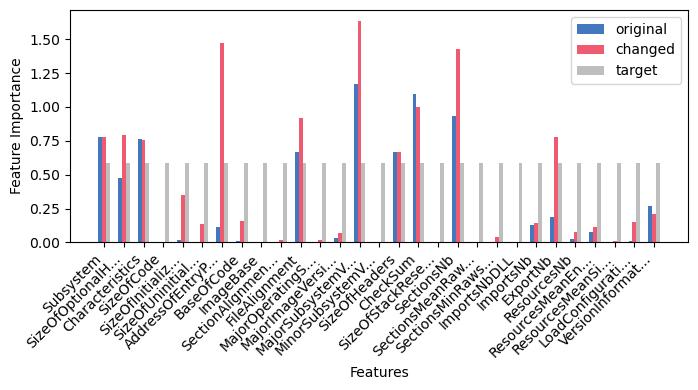

In [35]:
a.plot_explanation()

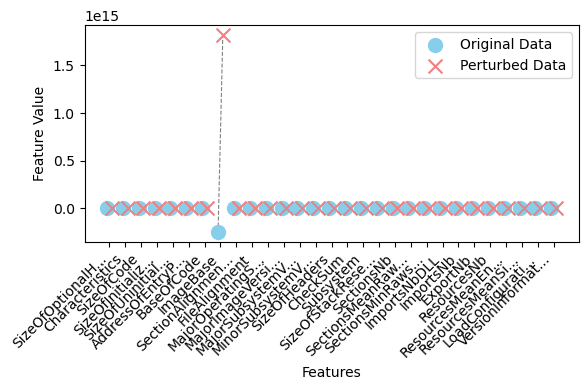

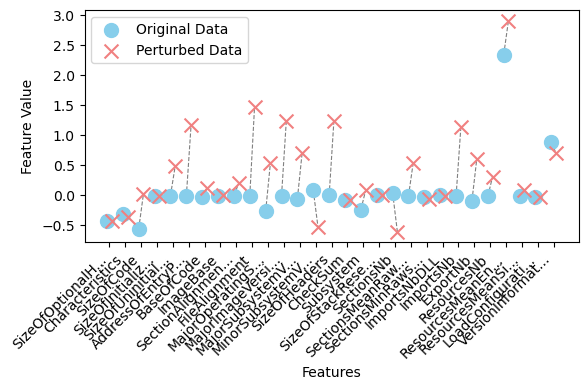

In [36]:
a.plot_data(scaler=scaler, numerical_features_scaled=VARIABLES_TO_CHANGE, all_feature_names=feature_names)
a.plot_data(all_feature_names=feature_names)

In [37]:
a.display_feature_rank_changes()


--- Feature Ranking Changes ---

Ranking Changes: Original vs. Changed Explanation
--------------------------------------------------
Feature 'CheckSum': Rank changed from 2 to 4
Feature 'Subsystem': Rank changed from 4 to 7
Feature 'Characteristics': Rank changed from 5 to 9
Feature 'SizeOfHeaders': Rank changed from 6 to 10
Feature 'FileAlignment': Rank changed from 7 to 5
Feature 'SizeOfOptionalHeader': Rank changed from 8 to 6
Feature 'VersionInformationSize': Rank changed from 9 to 12
Feature 'ExportNb': Rank changed from 10 to 8
Feature 'ImportsNb': Rank changed from 11 to 15
Feature 'AddressOfEntryPoint': Rank changed from 12 to 2
Feature 'ResourcesMeanEntropy': Rank changed from 13 to 17
Feature 'MajorImageVersion': Rank changed from 14 to 19
Feature 'ResourcesNb': Rank changed from 15 to 18
Feature 'SizeOfInitializedData': Rank changed from 16 to 11
Feature 'BaseOfCode': Rank changed from 17 to 13
Feature 'LoadConfigurationSize': Rank changed from 18 to 14
Feature 'SizeOfUnin